In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Define transforms for image normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing with mean 0.5 and std 0.5
])

# Load the Sign Language MNIST dataset
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

# Split features (images) and labels
train_labels = train_data['label'].values
train_images = train_data.drop(columns=['label']).values.reshape(-1, 28, 28, 1)

test_labels = test_data['label'].values
test_images = test_data.drop(columns=['label']).values.reshape(-1, 28, 28, 1)

# Custom dataset class for loading data into PyTorch
class SignLanguageMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Apply transform only if the transform exists and the image is a NumPy array
        if isinstance(image, torch.Tensor):  # If it's already a tensor, skip transforming
            if self.transform is not None:
                image = image.squeeze(0)  # Remove the channel dimension before applying ToTensor
                image = transforms.ToPILImage()(image)  # Convert tensor back to PIL for transforms
                image = self.transform(image)  # Apply any additional transforms
        return image, label


# Convert train and test images to PyTorch tensors and normalize
def numpy_to_tensor(images):
    # Normalize images by dividing by 255.0 and reshaping to (batch_size, channels, height, width)
    images = images / 255.0  # Scale to range [0, 1]
    return torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # Reshape to (batch_size, channels, height, width)

# Convert train and test images to tensors
train_images_tensor = numpy_to_tensor(train_images)
test_images_tensor = numpy_to_tensor(test_images)

# Create PyTorch datasets
train_dataset = SignLanguageMNISTDataset(train_images_tensor, train_labels, transform=transform)
test_dataset = SignLanguageMNISTDataset(test_images_tensor, test_labels, transform=transform)

# Split the dataset into sequential tasks (A-G, H-M, etc.)
class_indices = {
    'A-G': list(range(0, 7)),
    'H-M': list(range(7, 13)),
    'N-Y': list(range(13, 24)),
}

# Function to filter the dataset for specific class indices
def filter_dataset(dataset, labels, class_list):
    indices = [i for i, label in enumerate(labels) if label in class_list]
    filtered_images = dataset.images[indices]
    filtered_labels = labels[indices]
    return SignLanguageMNISTDataset(filtered_images, filtered_labels, transform=transform)

# Filter datasets for the first task (A-G)
train_task_1 = filter_dataset(train_dataset, train_labels, class_indices['A-G'])
test_task_1 = filter_dataset(test_dataset, test_labels, class_indices['A-G'])

# Create DataLoader for batch training
train_loader_1 = data.DataLoader(train_task_1, batch_size=64, shuffle=True)
test_loader_1 = data.DataLoader(test_task_1, batch_size=64, shuffle=False)

# Filter datasets for the first task (H-M)
train_task_2 = filter_dataset(train_dataset, train_labels, class_indices['H-M'])
test_task_2 = filter_dataset(test_dataset, test_labels, class_indices['H-M'])

# Create DataLoader for batch training
train_loader_2 = data.DataLoader(train_task_2, batch_size=64, shuffle=True)
test_loader_2 = data.DataLoader(test_task_2, batch_size=64, shuffle=False)

# Filter datasets for the first task (N-Y)
train_task_3 = filter_dataset(train_dataset, train_labels, class_indices['N-Y'])
test_task_3 = filter_dataset(test_dataset, test_labels, class_indices['N-Y'])

# Create DataLoader for batch training
train_loader_3 = data.DataLoader(train_task_3, batch_size=64, shuffle=True)
test_loader_3 = data.DataLoader(test_task_3, batch_size=64, shuffle=False)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=24):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the feature maps
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN(num_classes=24)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(train_loader, model, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Function to evaluate the model
def evaluate_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')




Training on Task 1 (A-G)
Epoch 1/5, Loss: 4.7438, Accuracy: 9.35%
Epoch 2/5, Loss: 1.4439, Accuracy: 64.96%
Epoch 3/5, Loss: 0.2648, Accuracy: 95.25%
Epoch 4/5, Loss: 0.0859, Accuracy: 98.88%
Epoch 5/5, Loss: 0.0448, Accuracy: 99.63%
Accuracy on test data: 99.28%
Training on Task 2 (H-M)
Epoch 1/5, Loss: 3.7354, Accuracy: 36.34%
Epoch 2/5, Loss: 0.5848, Accuracy: 86.15%
Epoch 3/5, Loss: 0.2991, Accuracy: 93.72%
Epoch 4/5, Loss: 0.1806, Accuracy: 96.37%
Epoch 5/5, Loss: 0.1252, Accuracy: 97.20%
Accuracy on test data: 95.35%
Training on Task 3 (N-Y)
Epoch 1/5, Loss: 7.8571, Accuracy: 8.01%
Epoch 2/5, Loss: 4.7285, Accuracy: 32.84%
Epoch 3/5, Loss: 3.9902, Accuracy: 56.36%
Epoch 4/5, Loss: 3.4495, Accuracy: 73.53%
Epoch 5/5, Loss: 3.1352, Accuracy: 80.87%
Accuracy on test data: 75.62%


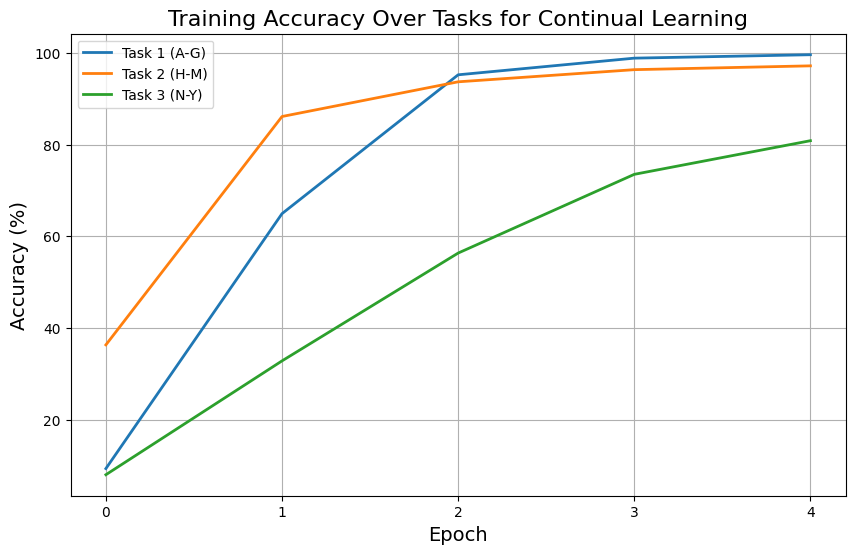

In [7]:
import torch
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

# Define the EWC loss function
class EWC:
    def __init__(self, model, dataloader, criterion):
        self.model = model
        self.dataloader = dataloader
        self.criterion = criterion
        self.fisher_information = None
        self.old_params = None

    def compute_fisher_information(self):
        fisher_information = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}
        self.model.eval()
        for images, labels in self.dataloader:
            self.model.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            for name, param in self.model.named_parameters():
                fisher_information[name] += param.grad**2 / len(self.dataloader)
        self.fisher_information = fisher_information

    def compute_ewc_loss(self):
        ewc_loss = 0
        if self.old_params and self.fisher_information:
            for name, param in self.model.named_parameters():
                old_param = self.old_params[name]
                fisher = self.fisher_information[name]
                ewc_loss += torch.sum(fisher * (param - old_param)**2)
        return ewc_loss

    def update_old_params(self):
        self.old_params = {name: param.clone() for name, param in self.model.named_parameters()}

# Initialize the EWC object
ewc = EWC(model, train_loader_1, criterion)

# Function to train the model with EWC
def train_model_with_ewc(train_loader, model, criterion, optimizer, ewc=None, num_epochs=5):
    model.train()
    task_losses = []
    task_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            if ewc:
                ewc_loss = ewc.compute_ewc_loss()
                loss += ewc_loss  # Add EWC loss to the original loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        task_losses.append(epoch_loss)
        task_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Update EWC parameters after training
    if ewc:
        ewc.update_old_params()

    return task_losses, task_accuracies

# Function to evaluate the model
def evaluate_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy on test data: {accuracy:.2f}%')
    return accuracy

# Track accuracies and losses
overall_accuracies = {
    'Task 1 (A-G)': [],
    'Task 2 (H-M)': [],
    'Task 3 (N-Y)': []
}

overall_losses = {
    'Task 1 (A-G)': [],
    'Task 2 (H-M)': [],
    'Task 3 (N-Y)': []
}

# Train and evaluate on Task 1 (A-G)
print("Training on Task 1 (A-G)")
losses_1, accuracies_1 = train_model_with_ewc(train_loader_1, model, criterion, optimizer, ewc)
overall_accuracies['Task 1 (A-G)'] = accuracies_1
overall_losses['Task 1 (A-G)'] = losses_1
evaluate_model(test_loader_1, model)

# Compute Fisher Information for Task 1
ewc.compute_fisher_information()

# Train and evaluate on Task 2 (H-M)
print("Training on Task 2 (H-M)")
losses_2, accuracies_2 = train_model_with_ewc(train_loader_2, model, criterion, optimizer, ewc)
overall_accuracies['Task 2 (H-M)'] = accuracies_2
overall_losses['Task 2 (H-M)'] = losses_2
evaluate_model(test_loader_2, model)

# Compute Fisher Information for Task 2
ewc.compute_fisher_information()

# Train and evaluate on Task 3 (N-Y)
print("Training on Task 3 (N-Y)")
losses_3, accuracies_3 = train_model_with_ewc(train_loader_3, model, criterion, optimizer, ewc)
overall_accuracies['Task 3 (N-Y)'] = accuracies_3
overall_losses['Task 3 (N-Y)'] = losses_3
evaluate_model(test_loader_3, model)

# Function to plot the performance
def plot_performance(overall_accuracies):
    plt.figure(figsize=(10, 6))

    for task, accuracies in overall_accuracies.items():
        plt.plot(range(len(accuracies)), accuracies, label=task, linewidth=2)

    plt.title("Training Accuracy Over Tasks for Continual Learning", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.xticks(range(len(accuracies)))  # Set x-ticks to match the number of epochs
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot the task accuracies after training
plot_performance(overall_accuracies)


In [ ]:
import torch
import torch.nn.functional as F
from torch import optim

# Train the model without any CL strategy
def train_model_naive(train_loader, model, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model
def evaluate_model(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

# Initialize the model, loss function, and optimizer
model_naive = CNN(num_classes=24)  # Make sure the model class (CNN) is defined
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_naive.parameters(), lr=0.001)

# Train and evaluate on Task 1 (A-G)
print("Training on Task 1 (A-G)")
train_model_naive(train_loader_1, model_naive, criterion, optimizer)
evaluate_model(test_loader_1, model_naive)

# Train and evaluate on Task 2 (H-M)
print("Training on Task 2 (H-M)")
train_model_naive(train_loader_2, model_naive, criterion, optimizer)
evaluate_model(test_loader_2, model_naive)

# Train and evaluate on Task 3 (N-Y)
print("Training on Task 3 (N-Y)")
train_model_naive(train_loader_3, model_naive, criterion, optimizer)
evaluate_model(test_loader_3, model_naive)


Training on Task 1 (A-G)
Epoch 1/5, Loss: 0.5781094817798739
Epoch 2/5, Loss: 0.013782972110096704
Epoch 3/5, Loss: 0.0026500108055308585
Epoch 4/5, Loss: 0.001122368277629745
Epoch 5/5, Loss: 0.0008130953678464871
Accuracy: 99.46%
Training on Task 2 (H-M)
Epoch 1/5, Loss: 1.2985429563347928
Epoch 2/5, Loss: 0.006754650483013724
Epoch 3/5, Loss: 0.0025290687378649386
Epoch 4/5, Loss: 0.001522875528528609
Epoch 5/5, Loss: 0.0009784747010350904
Accuracy: 98.55%
Training on Task 3 (N-Y)
Epoch 1/5, Loss: 1.7921590620250094
Epoch 2/5, Loss: 0.11168481344722357
Epoch 3/5, Loss: 0.02500317555477879
Epoch 4/5, Loss: 0.008728468039657409
Epoch 5/5, Loss: 0.004683416283703135
Accuracy: 89.21%


89.20967159870084

In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms

# Load the trained model (make sure the model is in evaluation mode)
model_naive.eval()

# Define a transformation to preprocess the frame
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean 0.5 and std 0.5
])

# Function to preprocess a frame
def preprocess_frame(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Resize to 28x28
    resized = cv2.resize(gray, (28, 28))
    # Normalize and convert to tensor
    tensor = transform(resized).unsqueeze(0)  # Add batch dimension
    return tensor

# Open a connection to the webcam
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Define region of interest for hand detection (you may need to adjust this)
    roi = frame[50:300, 50:300]  # Example coordinates for ROI

    # Convert to HSV color space for color segmentation (skin color detection)
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define the skin color range in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Threshold the HSV image to get only skin colors
    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour which is assumed to be the hand
        max_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_contour)

        # Extract the hand region and preprocess
        hand_img = roi[y:y+h, x:x+w]
        input_tensor = preprocess_frame(hand_img)

        # Run the hand image through the model
        with torch.no_grad():
            outputs = model_naive(input_tensor)
            _, predicted = torch.max(outputs.data, 1)

        # Get the predicted label
        predicted_label = chr(predicted.item() + ord('A'))  # Assuming labels 0-23 map to 'A'-'Y'

        # Draw bounding box and label on the original frame
        cv2.rectangle(frame, (50 + x, 50 + y), (50 + x + w, 50 + y + h), (0, 255, 0), 2)
        cv2.putText(frame, f'Predicted: {predicted_label}', (50 + x, 50 + y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Display the resulting frame
    cv2.imshow('Real-time Sign Language Recognition', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()
